Author: Yolanda Pan

Date: 02/24/2026

In [1]:
import os
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns


In [2]:
# Updated paths to match scripts/5_build_topic_network_cluster.py
CANDOR_DIR = '/project/ycleong/datasets/CANDOR'

NETWORK_PATH = os.path.join(CANDOR_DIR, 'cluster_edges_by_convo.parquet')
ANALYSIS_PATH = 'data/convo_features_outdegree_enjoyable.csv'

In [3]:
# ------------- io helpers -------------
def read_parquet_any(path: str) -> pd.DataFrame:
    """
    Read parquet using pyarrow if available, else fastparquet.
    """
    try:
        return pd.read_parquet(path, engine="pyarrow")
    except Exception:
        return pd.read_parquet(path, engine="fastparquet")


def write_parquet_any(df: pd.DataFrame, path: str) -> None:
    """
    Write parquet using pyarrow if available, else fastparquet.
    """
    try:
        df.to_parquet(path, engine="pyarrow", index=False)
    except Exception:
        df.to_parquet(path, engine="fastparquet", index=False)


## Main Effect

In [10]:
df = pd.read_csv(ANALYSIS_PATH)
df.head()

,convo_id,avg_out_degree,n_nodes,avg_how_enjoyable,conv_length_min,n_participants,sex_pair
0,0020a0c5-1658-4747-99c1-2839e736b481,1.533333,15,8.5,43.0,2,FM
1,002d68da-7738-4177-89d9-d72ae803e0e4,1.200000,10,8.0,34.0,2,FM
2,00411458-8275-4b92-a000-d52187f03604,1.166667,12,7.5,35.0,2,FM
3,00ae2f18-9599-4df6-8e3a-6936c86b97f0,1.555556,9,8.0,30.0,2,FF
4,00b410f7-8b5f-4404-8433-0fb8c4be8f62,1.500000,8,7.0,30.0,2,FM


In [11]:
df.describe()

,avg_out_degree,n_nodes,avg_how_enjoyable,conv_length_min,n_participants
count,1655.000000,1655.000000,1653.000000,1655.000000,1655.0
mean,1.274370,8.775227,7.413188,29.019940,2.0
std,0.226070,2.319986,1.183726,8.256372,0.0
min,0.666667,2.000000,1.500000,0.000000,2.0
25%,1.111111,7.000000,7.000000,26.000000,2.0
50%,1.250000,9.000000,7.500000,27.000000,2.0
75%,1.400000,10.000000,8.500000,30.000000,2.0
max,2.375000,18.000000,9.000000,88.000000,2.0


In [7]:
# df_long = df[df["conv_length_min"] >= 25].copy()

# df_long["n_nodes_z"] = (
#     df_long["n_nodes"] - df_long["n_nodes"].mean()
# ) / df_long["n_nodes"].std()

# df_long["avg_out_degree_z"] = (
#     df_long["avg_out_degree"] - df_long["avg_out_degree"].mean()
# ) / df_long["avg_out_degree"].std()


In [18]:
scaler = StandardScaler()

df[["avg_out_degree_z", "n_nodes_z"]] = scaler.fit_transform(
    df[["avg_out_degree", "n_nodes"]]
)

In [19]:
# print(df_long.describe())
# print(df_long.isna().mean())


In [20]:
df = df.dropna(subset=["avg_out_degree", "n_nodes", "avg_how_enjoyable"])

In [21]:
df = df.dropna(subset=["avg_how_enjoyable"])

In [22]:
print(df.describe())
print(df.isna().mean())

       avg_out_degree      n_nodes  avg_how_enjoyable  conv_length_min  \
count     1653.000000  1653.000000        1653.000000      1653.000000   
mean         1.274313     8.777374           7.413188        29.032668   
std          0.226160     2.319524           1.183726         8.252347   
min          0.666667     2.000000           1.500000         0.000000   
25%          1.111111     7.000000           7.000000        26.000000   
50%          1.250000     9.000000           7.500000        27.000000   
75%          1.400000    10.000000           8.500000        30.000000   
max          2.375000    18.000000           9.000000        88.000000   

       n_participants  avg_out_degree_z     n_nodes_z  
count          1653.0      1.653000e+03  1.653000e+03  
mean              2.0     -7.221487e-16  2.622088e-16  
std               0.0      1.000303e+00  1.000303e+00  
min               2.0     -2.687607e+00 -2.922766e+00  
25%               2.0     -7.218370e-01 -7.664989e-01

In [23]:
corr_vars = df[["avg_how_enjoyable", "avg_out_degree", "n_nodes","conv_length_min"]]
corr_matrix = corr_vars.corr(method="pearson")
print(corr_matrix.round(3))

                   avg_how_enjoyable  avg_out_degree  n_nodes  conv_length_min
avg_how_enjoyable              1.000           0.175    0.100            0.221
avg_out_degree                 0.175           1.000    0.189            0.303
n_nodes                        0.100           0.189    1.000            0.250
conv_length_min                0.221           0.303    0.250            1.000


In [24]:
# Pearson correlation: n_nodes vs conv_length_min
r, p = pearsonr(df["n_nodes"], df["conv_length_min"])
print(f"Pearson r(n_nodes, conv_length_min) = {r:.4f}, p = {p:.4e}")

Pearson r(n_nodes, conv_length_min) = 0.2504, p = 4.6837e-25


### Figures

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import sem, t

def clean_style(ax):
    ax.set_facecolor("white")
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(axis="both", length=0)
    ax.grid(True, axis="y", linewidth=0.6, alpha=0.18)
    ax.set_axisbelow(True)

def plot_binned_mean_ci(
    x, y, xlabel, ylabel, title,
    *,
    n_bins=8,
    show_raw=True,
    raw_alpha=0.08,
    raw_s=10,
    use_median=False,
    y_limits="auto",        # "auto" | (low, high) | None
    y_pad_frac=0.15,
    x_pad_frac=0.06,
    bootstrap_n=800,
    random_state=0,
    # NEW: colors
    summary_color="black",      # try "black" or "#222222"
    raw_color="#9e9e9e",        # light gray points
    
):
    mask = x.notna() & y.notna()
    x = x[mask].astype(float)
    y = y[mask].astype(float)

    r, p = pearsonr(x, y)

    bins = pd.qcut(x, q=n_bins, duplicates="drop")
    dfb = pd.DataFrame({"x": x, "y": y, "bin": bins})

    rows = []
    rng = np.random.default_rng(random_state)

    for b, g in dfb.groupby("bin", sort=True):
        yy = g["y"].values
        center = np.median(yy) if use_median else np.mean(yy)

        if use_median:
            boots = np.empty(bootstrap_n)
            for i in range(bootstrap_n):
                boots[i] = np.median(rng.choice(yy, size=len(yy), replace=True))
            lo, hi = np.quantile(boots, [0.025, 0.975])
        else:
            n = len(yy)
            se = sem(yy)
            h = t.ppf(0.975, df=max(n - 1, 1)) * se
            lo, hi = center - h, center + h

        xmid = (b.left + b.right) / 2
        rows.append({"xmid": xmid, "lo": lo, "hi": hi, "center": center})

    summ = pd.DataFrame(rows).sort_values("xmid").reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(6.2, 4.8), facecolor="white")

    if show_raw:
        ax.scatter(
            x.values, y.values,
            s=raw_s,
            alpha=raw_alpha,
            color=raw_color,
            edgecolors="none"
        )

    # mean/median with CI (colored)
    ax.errorbar(
        summ["xmid"], summ["center"],
        yerr=[summ["center"] - summ["lo"], summ["hi"] - summ["center"]],
        fmt="o-",
        color=summary_color,           # line + markers
        ecolor=summary_color,          # error bars
        capsize=3,
        linewidth=2,
        markersize=5,
        markerfacecolor=summary_color,
        markeredgecolor=summary_color
    )

    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=12, pad=8)

    ax.text(
        0.02, 0.98,
        f"$r$ = {r:.2f}, $p$ = {p:.1e}",
        transform=ax.transAxes,
        ha="left", va="top", fontsize=10,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.9, pad=2.5)
    )

    x_rng = float(x.max() - x.min())
    if x_rng < 1e-12:
        x_rng = 1.0
    ax.set_xlim(x.min() - x_pad_frac * x_rng, x.max() + x_pad_frac * x_rng)

    if y_limits == "auto":
        y_lo = float(summ["lo"].min())
        y_hi = float(summ["hi"].max())
        y_rng = y_hi - y_lo
        if y_rng < 1e-12:
            y_rng = 1.0
        pad = y_pad_frac * y_rng
        ax.set_ylim(y_lo - pad, y_hi + pad)
    elif isinstance(y_limits, tuple) and len(y_limits) == 2:
        ax.set_ylim(*y_limits)
    elif y_limits is None:
        pass
    else:
        raise ValueError('y_limits must be "auto", a (low, high) tuple, or None.')

    clean_style(ax)
    plt.tight_layout()
    plt.show()


/home/xpan02/ipykernel_2318566/3996607266.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for b, g in dfb.groupby("bin", sort=True):


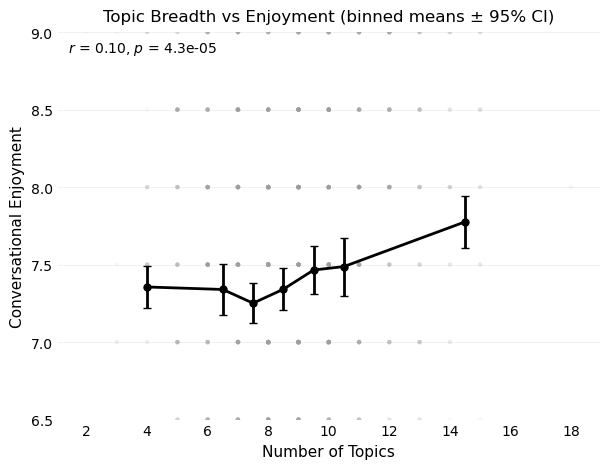

In [26]:
plot_binned_mean_ci(
    df["n_nodes"], df["avg_how_enjoyable"],
    xlabel="Number of Topics",
    ylabel="Conversational Enjoyment",
    title="Topic Breadth vs Enjoyment (binned means ± 95% CI)",
    n_bins=8,
    y_limits=(6.5, 9)
)

/home/xpan02/ipykernel_2318566/3996607266.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for b, g in dfb.groupby("bin", sort=True):


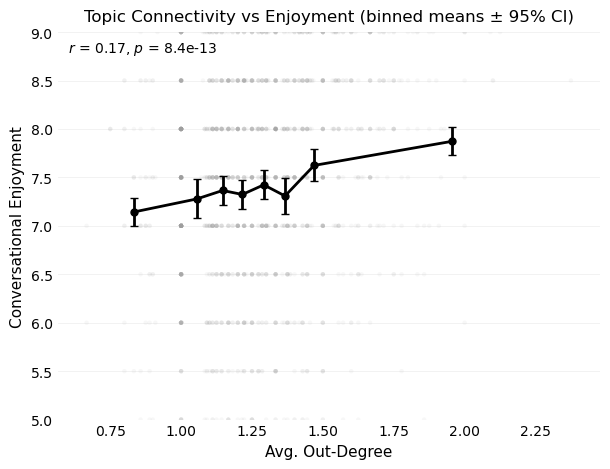

In [27]:
plot_binned_mean_ci(
    df["avg_out_degree"], df["avg_how_enjoyable"],
    xlabel="Avg. Out-Degree",
    ylabel="Conversational Enjoyment",
    title="Topic Connectivity vs Enjoyment (binned means ± 95% CI)",
    n_bins=8,
    use_median=False,
    y_limits=(5, 9)
)


### Models

In [28]:
r, p = pearsonr(df["n_nodes_z"], df["conv_length_min"])
print(f"Pearson r(n_nodes_z, conv_length_min) = {r:.4f}, p = {p:.4e}")

Pearson r(n_nodes_z, conv_length_min) = 0.2504, p = 4.6837e-25


In [29]:
r, p = pearsonr(df["avg_how_enjoyable"], df["conv_length_min"])
print(f"Pearson r(avg_how_enjoyable, conv_length_min) = {r:.4f}, p = {p:.4e}")

Pearson r(avg_how_enjoyable, conv_length_min) = 0.2207, p = 1.0854e-19


Pearson r(avg_how_enjoyable, conv_length_min) = 0.2207, p = 1.0854e-19


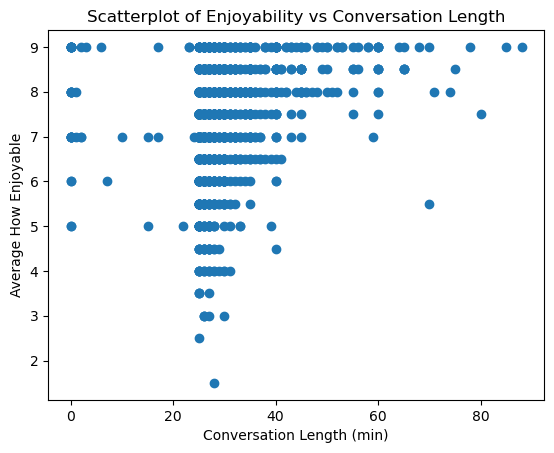

In [30]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Compute correlation
r, p = pearsonr(df["avg_how_enjoyable"], df["conv_length_min"])
print(f"Pearson r(avg_how_enjoyable, conv_length_min) = {r:.4f}, p = {p:.4e}")

# Scatterplot
plt.figure()
plt.scatter(df["conv_length_min"], df["avg_how_enjoyable"])

plt.xlabel("Conversation Length (min)")
plt.ylabel("Average How Enjoyable")
plt.title("Scatterplot of Enjoyability vs Conversation Length")

plt.show()


In [32]:
x = df["conv_length_min"]
print("min:", x.min(), "num<=0:", (x<=0).sum(), "num_nan:", x.isna().sum(), "num_inf:", np.isinf(x).sum())


min: 0.0 num<=0: 26 num_nan: 0 num_inf: 0


In [39]:
short_convo = df[df["conv_length_min"] <= 10].copy()

print(short_convo[["convo_id", "conv_length_min", "n_nodes", "avg_how_enjoyable"]])


                                  convo_id  conv_length_min  n_nodes  \
23    0278950b-a7e0-4e15-8a2b-1629ff1b17ba              0.0       10   
26    030c76ab-9e19-4b78-9a7a-86cd7ba8472a              0.0       10   
63    0a84a137-b947-441c-b94c-a03f4a5851ea              2.0        9   
101   115ba192-7e26-497b-85b2-adf378b33387              0.0       10   
111   13f6956b-ff2a-4ad3-aed6-8fd3cfdb2cd4              3.0       13   
138   17dbcae3-0087-49c6-af7c-c92099e3377a              0.0       13   
175   1e3c22d6-422c-4921-8892-e31e09f9a2f6              0.0        5   
194   20bc98a3-efaa-4657-8448-f731bdec47cb              0.0        6   
203   22579311-0848-472a-a1b7-9b663fbb4aab              1.0        8   
247   29f8f496-079b-4a71-84ff-7100bbc28824              0.0        7   
305   3045ec04-252c-420e-8646-c6b0e150ca74              0.0        7   
318   32adb5d5-910d-4547-972a-f5d0b795c689              0.0       10   
463   49694675-cacf-452d-a940-3c93987126ef              1.0     

In [41]:
# long_df = df[df["conv_length_min"] > 50].copy()

# print("Number of conversations >60min:", len(long_df))
# print(long_df[["conv_length_min", "n_nodes", "avg_how_enjoyable"]].head())

# long_df.sort_values("conv_length_min", ascending=False)

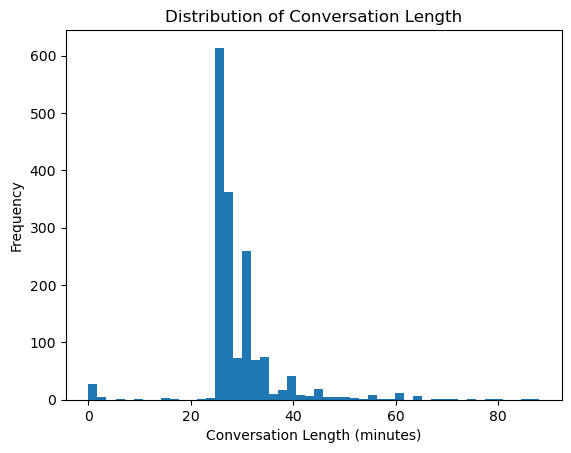

In [42]:
import matplotlib.pyplot as plt
import numpy as np

x = df["conv_length_min"]

# Clean data
x_clean = x.replace([np.inf, -np.inf], np.nan).dropna()

plt.figure()
plt.hist(x_clean, bins=50)
plt.xlabel("Conversation Length (minutes)")
plt.ylabel("Frequency")
plt.title("Distribution of Conversation Length")
plt.show()


In [43]:
# import matplotlib.pyplot as plt
# import numpy as np

# x = df["log_conv_length"]

# # Clean data
# x_clean = x.replace([np.inf, -np.inf], np.nan).dropna()

# plt.figure()
# plt.hist(x_clean, bins=50)
# plt.xlabel("Log Conversation Length (minutes)")
# plt.ylabel("Frequency")
# plt.title("Distribution of Conversation Length")
# plt.show()


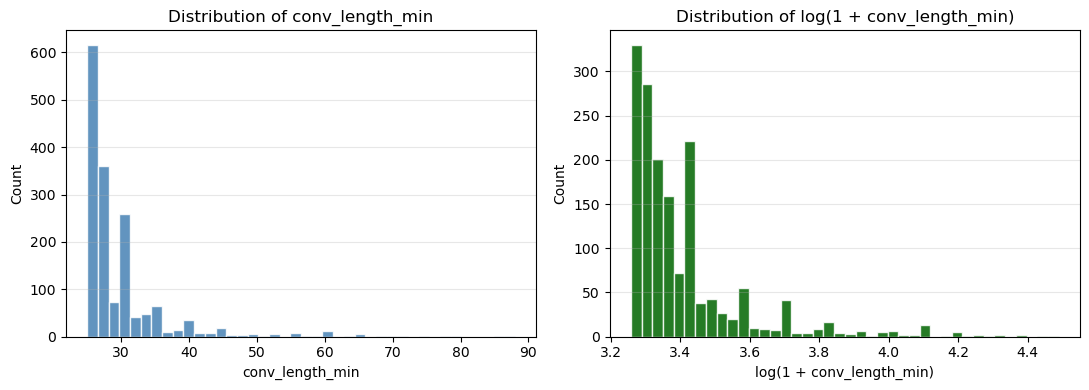

In [44]:
# Distribution of conv_length_min and log(1 + conv_length_min)
fig, axes = plt.subplots(1, 2, figsize=(11, 4), facecolor="white")

# conv_length_min
ax0 = axes[0]
ax0.hist(df_long["conv_length_min"].dropna(), bins=40, color="steelblue", edgecolor="white", alpha=0.85)
ax0.set_xlabel("conv_length_min")
ax0.set_ylabel("Count")
ax0.set_title("Distribution of conv_length_min")
ax0.grid(True, axis="y", alpha=0.3)

# log(1 + conv_length_min)
if "log_conv_length" not in df_long.columns:
    df["log_conv_length"] = np.log1p(df_long["conv_length_min"])
ax1 = axes[1]
ax1.hist(df["log_conv_length"].dropna(), bins=40, color="darkgreen", edgecolor="white", alpha=0.85)
ax1.set_xlabel("log(1 + conv_length_min)")
ax1.set_ylabel("Count")
ax1.set_title("Distribution of log(1 + conv_length_min)")
ax1.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# df_long["log_conv_length"] = np.log1p(df_long["conv_length_min"])


In [45]:
# ----------------------------
# Model 1:
# avg_how_enjoyable ~ avg_out_degree + n_nodes
# (both standardized)
# ----------------------------
m1 = smf.ols(
    "avg_how_enjoyable ~ avg_out_degree_z + n_nodes_z + conv_length_min + sex_pair",
    data=df
).fit()

print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:      avg_how_enjoyable   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     20.53
Date:                Tue, 24 Feb 2026   Prob (F-statistic):           2.74e-23
Time:                        13:55:13   Log-Likelihood:                -2564.2
No. Observations:                1653   AIC:                             5142.
Df Residuals:                    1646   BIC:                             5180.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.7309      0.129  

In [25]:
# ----------------------------
# Model 2:
# avg_how_enjoyable ~ avg_out_degree
# ----------------------------
m2 = smf.ols(
    "avg_how_enjoyable ~ avg_out_degree_z + conv_length_min + sex_pair",
    data=df
).fit()

print("\nMODEL 2: avg_how_enjoyable ~ avg_out_degree_z")
print(m2.summary())


MODEL 2: avg_how_enjoyable ~ avg_out_degree_z
                            OLS Regression Results                            
Dep. Variable:      avg_how_enjoyable   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     24.42
Date:                Tue, 24 Feb 2026   Prob (F-statistic):           8.68e-24
Time:                        13:53:27   Log-Likelihood:                -2564.7
No. Observations:                1653   AIC:                             5141.
Df Residuals:                    1647   BIC:                             5174.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [26]:
# ----------------------------
# Model 3:
# avg_how_enjoyable ~ n_nodes
# ----------------------------
m3 = smf.ols(
    "avg_how_enjoyable ~ n_nodes_z + conv_length_min + sex_pair",
    data=df
).fit()

print("\nMODEL 3: avg_how_enjoyable ~ n_nodes_z")
print(m3.summary())



MODEL 3: avg_how_enjoyable ~ n_nodes_z
                            OLS Regression Results                            
Dep. Variable:      avg_how_enjoyable   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     20.96
Date:                Tue, 24 Feb 2026   Prob (F-statistic):           2.32e-20
Time:                        13:53:29   Log-Likelihood:                -2572.8
No. Observations:                1653   AIC:                             5158.
Df Residuals:                    1647   BIC:                             5190.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
In

#### Interaction

In [27]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[["avg_out_degree_z", "n_nodes_z", "conv_length_min"]]
X = sm.add_constant(X)

for i in range(X.shape[1]):
    print(X.columns[i], variance_inflation_factor(X.values, i))


const 15.212993809408196
avg_out_degree_z 1.1176033830757255
n_nodes_z 1.0834849390575787
conv_length_min 1.1497636575526744


In [28]:
# Model 4: interaction
model_4 = smf.ols(
    "avg_how_enjoyable ~ avg_out_degree_z * n_nodes_z + conv_length_min + sex_pair",
    data=df
).fit(cov_type="HC3")

print(model_4.summary())


                            OLS Regression Results                            
Dep. Variable:      avg_how_enjoyable   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     21.49
Date:                Tue, 24 Feb 2026   Prob (F-statistic):           6.89e-28
Time:                        13:53:35   Log-Likelihood:                -2563.6
No. Observations:                1653   AIC:                             5143.
Df Residuals:                    1645   BIC:                             5187.
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

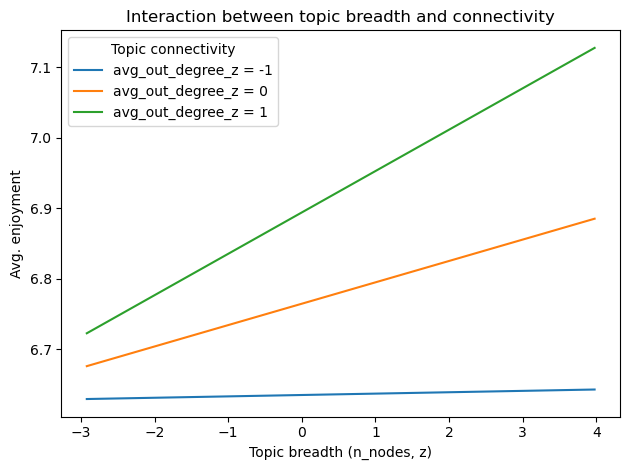

In [29]:
# low / mean / high connectivity
levels = [-1, 0, 1]
x = np.linspace(df["n_nodes_z"].min(), df["n_nodes_z"].max(), 100)

plt.figure()
for lvl in levels:
    y = (
        model_4.params["Intercept"]
        + model_4.params["n_nodes_z"] * x
        + model_4.params["avg_out_degree_z"] * lvl
        + model_4.params["avg_out_degree_z:n_nodes_z"] * x * lvl
    )
    plt.plot(x, y, label=f"avg_out_degree_z = {lvl}")

plt.xlabel("Topic breadth (n_nodes, z)")
plt.ylabel("Avg. enjoyment")
plt.title("Interaction between topic breadth and connectivity")
plt.legend(title="Topic connectivity")
plt.tight_layout()
plt.show()


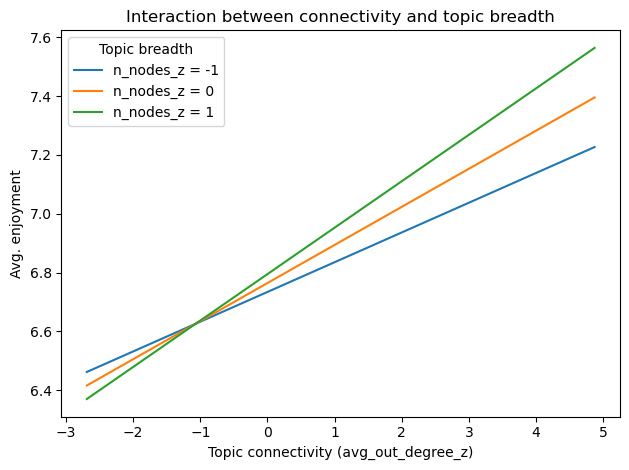

In [30]:
# low / mean / high topic breadth
levels = [-1, 0, 1]
x = np.linspace(df["avg_out_degree_z"].min(), df["avg_out_degree_z"].max(), 100)

plt.figure()
for lvl in levels:
    y = (
        model_4.params["Intercept"]
        + model_4.params["avg_out_degree_z"] * x
        + model_4.params["n_nodes_z"] * lvl
        + model_4.params["avg_out_degree_z:n_nodes_z"] * x * lvl
    )
    plt.plot(x, y, label=f"n_nodes_z = {lvl}")

plt.xlabel("Topic connectivity (avg_out_degree_z)")
plt.ylabel("Avg. enjoyment")
plt.title("Interaction between connectivity and topic breadth")
plt.legend(title="Topic breadth")
plt.tight_layout()
plt.show()


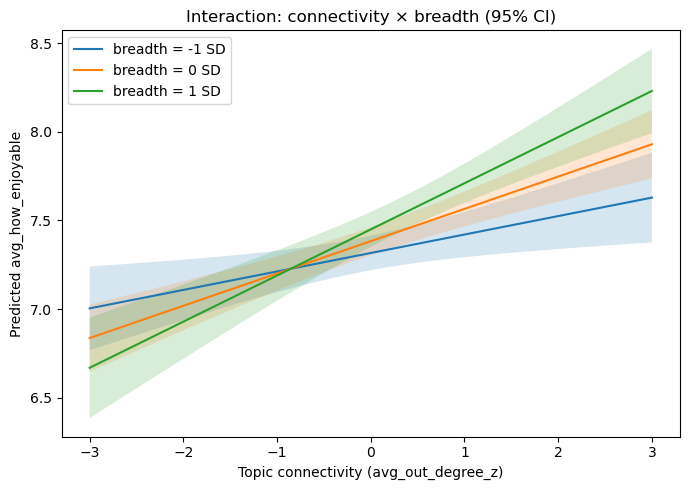

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

model_int = model_4  # <-- your fitted model

sex_ref = df["sex_pair"].mode().iloc[0]
log_len_ref = df["log_conv_length"].mean()

# x-axis: connectivity
x = np.linspace(-3, 3, 81)

# lines: breadth levels
levels = [-1, 0, 1]  # n_nodes_z levels

plt.figure(figsize=(7, 5))

for b in levels:
    grid = pd.DataFrame({
        "avg_out_degree_z": x,
        "n_nodes_z": b,
        "log_conv_length": log_len_ref,
        "sex_pair": sex_ref
    })
    pred = model_int.get_prediction(grid).summary_frame(alpha=0.05)
    plt.plot(x, pred["mean"], label=f"breadth = {b} SD")
    plt.fill_between(x, pred["mean_ci_lower"], pred["mean_ci_upper"], alpha=0.18)

plt.xlabel("Topic connectivity (avg_out_degree_z)")
plt.ylabel("Predicted avg_how_enjoyable")
plt.title("Interaction: connectivity × breadth (95% CI)")
plt.legend()
plt.tight_layout()
plt.show()


### Visualization

In [25]:
print("N rows:", len(df))
print("Unique (x,y) coords:", df[["n_nodes_z","avg_out_degree_z"]].drop_duplicates().shape[0])


N rows: 1653
Unique (x,y) coords: 128


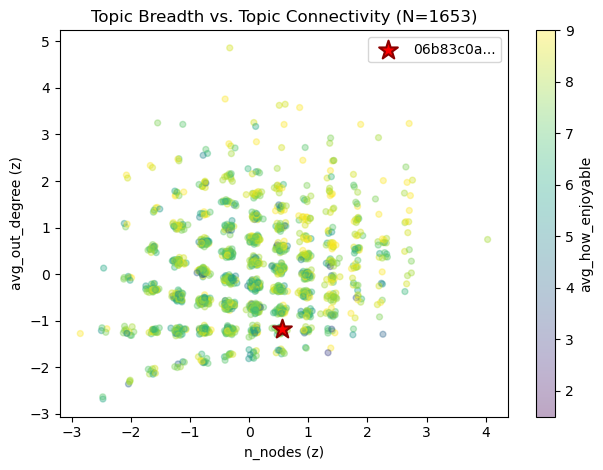

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# jitter helps separate identical coordinates
rng = np.random.default_rng(42)
x = df["n_nodes_z"].to_numpy() + rng.normal(0, 0.05, size=len(df))
y = df["avg_out_degree_z"].to_numpy() + rng.normal(0, 0.05, size=len(df))
c = df["avg_how_enjoyable"].to_numpy()

plt.figure()
sc = plt.scatter(x, y, c=c, alpha=0.35, s=18)  # alpha makes overlap visible

# Optional: highlight a specific dialogue (change convo_id to paint another)
highlight_id = "06b83c0a-7bf1-4cf9-9e72-034615d97050"
one = df[df["convo_id"] == highlight_id]
if len(one) > 0:
    x1 = one["n_nodes_z"].to_numpy() + rng.normal(0, 0.05, size=len(one))
    y1 = one["avg_out_degree_z"].to_numpy() + rng.normal(0, 0.05, size=len(one))
    plt.scatter(x1, y1, c="red", s=200, marker="*", edgecolors="darkred", linewidths=1.5, label=highlight_id[:8] + "...", zorder=5)
    plt.legend()

plt.xlabel("n_nodes (z)")
plt.ylabel("avg_out_degree (z)")
plt.title(f"Topic Breadth vs. Topic Connectivity (N={len(df)})")
plt.colorbar(sc, label="avg_how_enjoyable")
plt.tight_layout()
plt.show()


## Networks (within conversation)

In [27]:
def pick_convos_at_quantiles(df: pd.DataFrame, col: str, quantiles=(0.0, 0.25, 0.5, 0.75, 1.0)) -> pd.DataFrame:
    """
    Return a small table with the convo_id closest to each quantile target of df[col].
    """
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in convo feature df.")

    d = df[["convo_id", col]].dropna().copy()

    targets = d[col].quantile(list(quantiles)).to_dict()

    rows = []
    for q, target_val in targets.items():
        # pick the real convo whose value is closest to this target
        idx = (d[col] - target_val).abs().idxmin()
        rows.append({
            "quantile": q,
            "target_value": float(target_val),
            "picked_convo_id": d.loc[idx, "convo_id"],
            "picked_value": float(d.loc[idx, col]),
        })

    out = pd.DataFrame(rows).sort_values("quantile").reset_index(drop=True)
    return out


In [28]:
out = pick_convos_at_quantiles(df = df, col = 'avg_out_degree', quantiles=(0.0, 0.25, 0.5, 0.75, 1.0))
out

,quantile,target_value,picked_convo_id,picked_value
0,0.00,0.666667,491f9074-6f14-4ecd-a809-700599d28d82,0.666667
1,0.25,1.111111,01a4c01c-cf0e-4f37-ab2b-641bb604af30,1.111111
2,0.50,1.250000,03d82c5a-c923-47de-90f8-621776ff6cbc,1.250000
3,0.75,1.400000,021cae92-8043-4ef1-b115-47b539bad870,1.400000
4,1.00,2.375000,a9ca3b45-894c-4d00-9428-e76a0cac8211,2.375000


In [29]:
edges_all = read_parquet_any(NETWORK_PATH)
edges_all


,conversation_id,source,target,weight
0,0020a0c5-1658-4747-99c1-2839e736b481,25.0,19.0,2
1,0020a0c5-1658-4747-99c1-2839e736b481,8.0,25.0,2
2,0020a0c5-1658-4747-99c1-2839e736b481,0.0,18.0,1
3,0020a0c5-1658-4747-99c1-2839e736b481,0.0,20.0,1
4,0020a0c5-1658-4747-99c1-2839e736b481,0.0,4.0,1
...,...,...,...,...
18667,fffda3e6-7d99-4db8-aa12-16e99fa454c2,15.0,17.0,1
18668,fffda3e6-7d99-4db8-aa12-16e99fa454c2,17.0,12.0,1
18669,fffda3e6-7d99-4db8-aa12-16e99fa454c2,17.0,3.0,1
18670,fffda3e6-7d99-4db8-aa12-16e99fa454c2,26.0,12.0,1


In [30]:
edges_all.columns.tolist()


['conversation_id', 'source', 'target', 'weight']

In [53]:
def build_nx_graph(edges_df: pd.DataFrame,
                   source_col="source_topic",
                   target_col="target_topic",
                   weight_col=None,
                   directed=True) -> nx.Graph:
    """
    Build a NetworkX graph from an edges dataframe.
    """
    G = nx.DiGraph() if directed else nx.Graph()

    if weight_col and weight_col in edges_df.columns:
        for s, t, w in edges_df[[source_col, target_col, weight_col]].itertuples(index=False):
            if pd.isna(s) or pd.isna(t):
                continue
            G.add_edge(str(s), str(t), weight=float(w))
    else:
        for s, t in edges_df[[source_col, target_col]].itertuples(index=False):
            if pd.isna(s) or pd.isna(t):
                continue
            G.add_edge(str(s), str(t))

    return G

In [54]:
def draw_graph_pretty(
    G,
    title=None,
    save_path=None,
    seed=42,
    show_labels=True,
    graph_color="#1f77b4",
    node_colors=None,
    pos=None,
):
    plt.figure(figsize=(10, 8))

    if pos is None:
        pos = nx.spring_layout(G, seed=seed, k=1.8, iterations=200)

    node_size = 720

    # edge widths by weight
    weights = [G[u][v].get("weight", 1.0) for u, v in G.edges()]
    if len(weights) > 0:
        w = np.array(weights)
        edge_widths = 1.2 + 2.5 * (w / (w.max() + 1e-9))
    else:
        edge_widths = 1.5

    nx.draw_networkx_edges(
        G, pos,
        arrows=True,
        arrowstyle="-|>",
        arrowsize=14,
        width=edge_widths,
        alpha=0.8,
        edge_color="#333333",
        connectionstyle="arc3,rad=0.08",
    )

    if node_colors is not None:
        for color in set(node_colors.values()):
            nodelist = [n for n in G.nodes() if node_colors.get(n) == color]
            if nodelist:
                nx.draw_networkx_nodes(
                    G, pos,
                    nodelist=nodelist,
                    node_size=node_size,
                    node_color=color,
                    alpha=0.98,
                    linewidths=1.8,
                    edgecolors="#1a1a1a",
                )
    else:
        nx.draw_networkx_nodes(
            G, pos,
            node_size=node_size,
            node_color=graph_color,
            alpha=0.98,
            linewidths=1.8,
            edgecolors="#1a1a1a",
        )

    # labele
    if show_labels:
        nx.draw_networkx_labels(
            G, pos,
            font_size=10,
            font_color="black",
            bbox=dict(
                facecolor="white",
                edgecolor="#cccccc",
                linewidth=0.5,
                alpha=0.9,
                boxstyle="round,pad=0.25"
            ),
        )

    if title:
        plt.title(title, fontsize=12, pad=10)

    plt.axis("off")
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()
    plt.close()


In [64]:
def draw_convo_network(
    convo_id: str,
    edges_all: pd.DataFrame,
    df: pd.DataFrame = None,
    *,
    save_path: str = None,
    red_nodes: list = None,
    blue_nodes: list = None,
    two_color: bool = False,
    show_labels: bool = False,
    source_col: str = "source",
    target_col: str = "target",
    weight_col: str = "weight",
    conversation_id_col: str = "conversation_id",
    layout_seed: int = 42,
    graph_color: str = "#1f77b4",
) -> nx.DiGraph:
    """
    Draw the topic network for one conversation. Reusable: pass convo_id and edges_all (and optionally df for title).

    By default all nodes use graph_color. Set two_color=True for layout-based red/blue (left/right), or pass
    red_nodes and blue_nodes to color specific nodes.
    """
    edges_df = edges_all[edges_all[conversation_id_col] == convo_id]
    if len(edges_df) == 0:
        raise ValueError(f"No edges found for conversation {convo_id}")

    G = build_nx_graph(
        edges_df,
        source_col=source_col,
        target_col=target_col,
        weight_col=weight_col,
        directed=True,
    )

    pos = nx.spring_layout(G, seed=layout_seed, k=1.8, iterations=200)

    if red_nodes is not None and blue_nodes is not None:
        node_colors = {n: "#d62728" for n in red_nodes}
        for n in blue_nodes:
            node_colors[n] = "#1f77b4"
    elif two_color:
        xs = [pos[n][0] for n in G.nodes()]
        mid = np.median(xs)
        node_colors = {n: "#d62728" if pos[n][0] < mid else "#1f77b4" for n in G.nodes()}
    else:
        node_colors = None

    if df is not None and "convo_id" in df.columns:
        row = df[df["convo_id"] == convo_id]
        if len(row) > 0:
            r = row.iloc[0]
            n_nodes = int(r.get("n_nodes", G.number_of_nodes()))
            deg = float(r.get("avg_out_degree", 0))
            title = f"n_nodes={n_nodes}, avg_out_degree={deg:.3f}\n{convo_id}"
        else:
            title = convo_id
    else:
        title = convo_id

    draw_graph_pretty(
        G,
        title=title,
        save_path=save_path,
        seed=layout_seed,
        show_labels=show_labels,
        graph_color=graph_color,
        node_colors=node_colors,
        pos=pos,
    )
    return G

In [65]:
QUANTILE_COLORS = {
    0.00: "#1f77b4",  
    0.25: "#2ca02c",  
    0.50: "#ff7f0e",  
    0.75: "#9467bd",  
    1.00: "#d62728",  
}


In [56]:
FIG_DIR = "./figures"

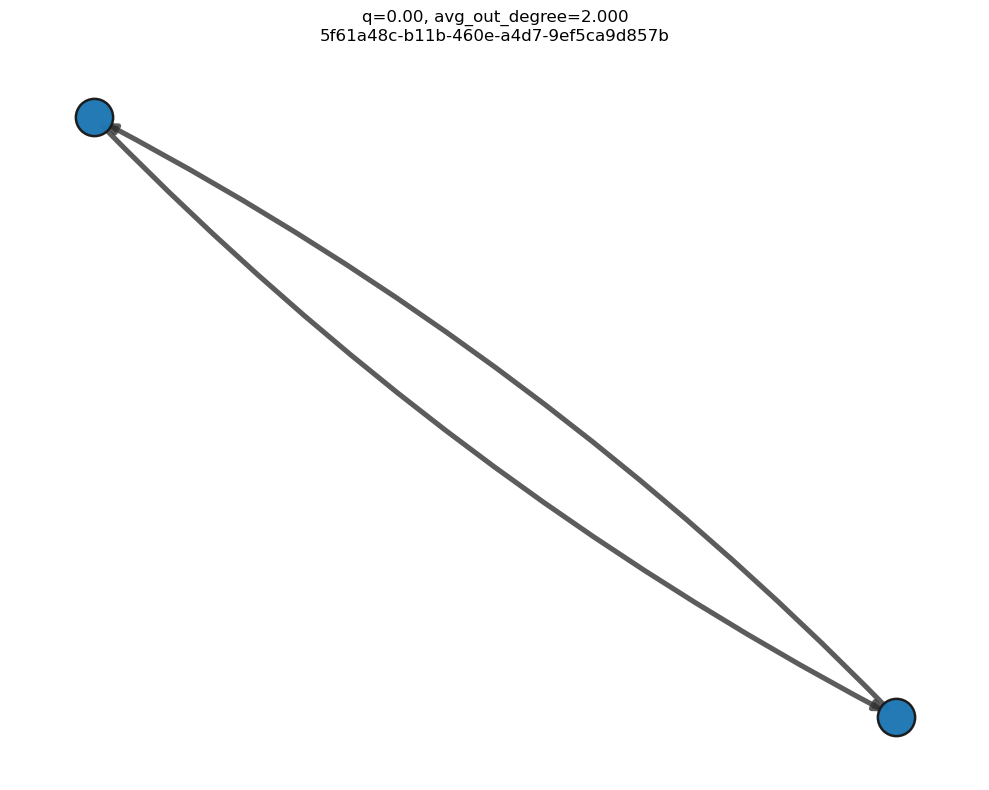

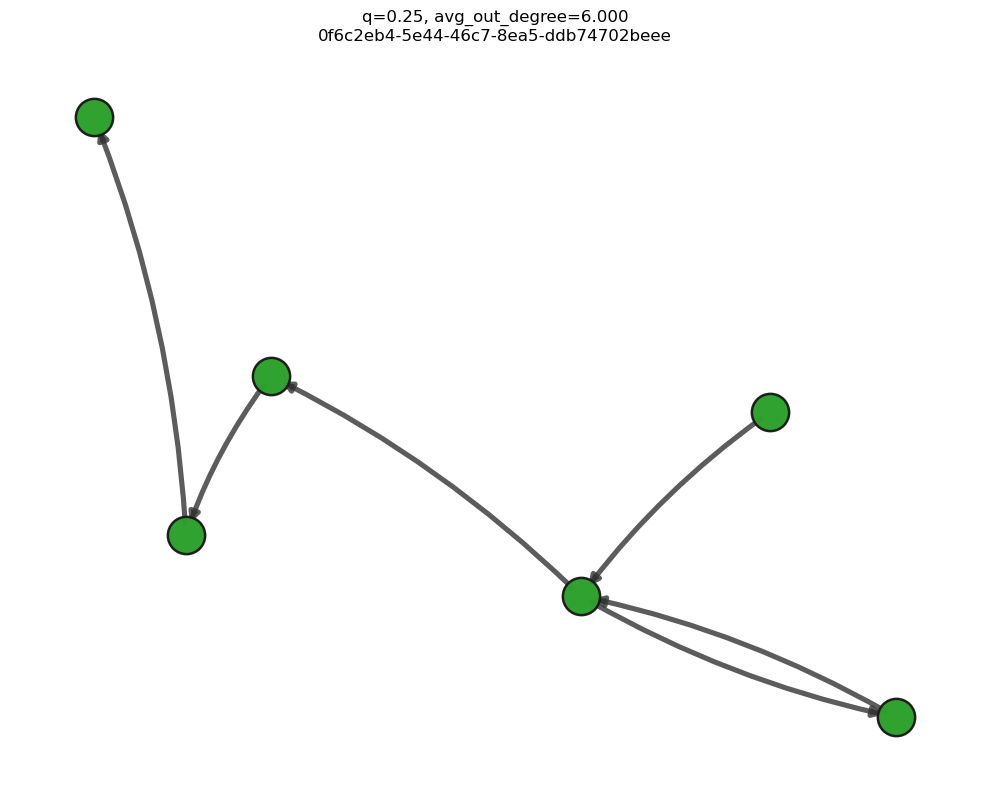

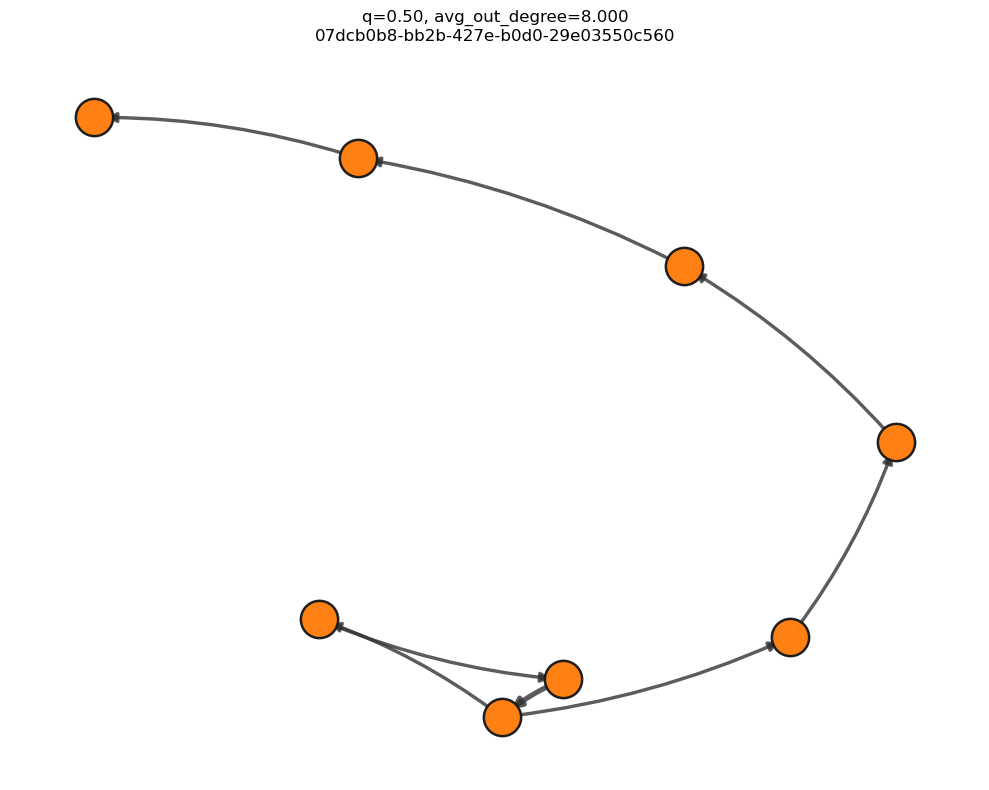

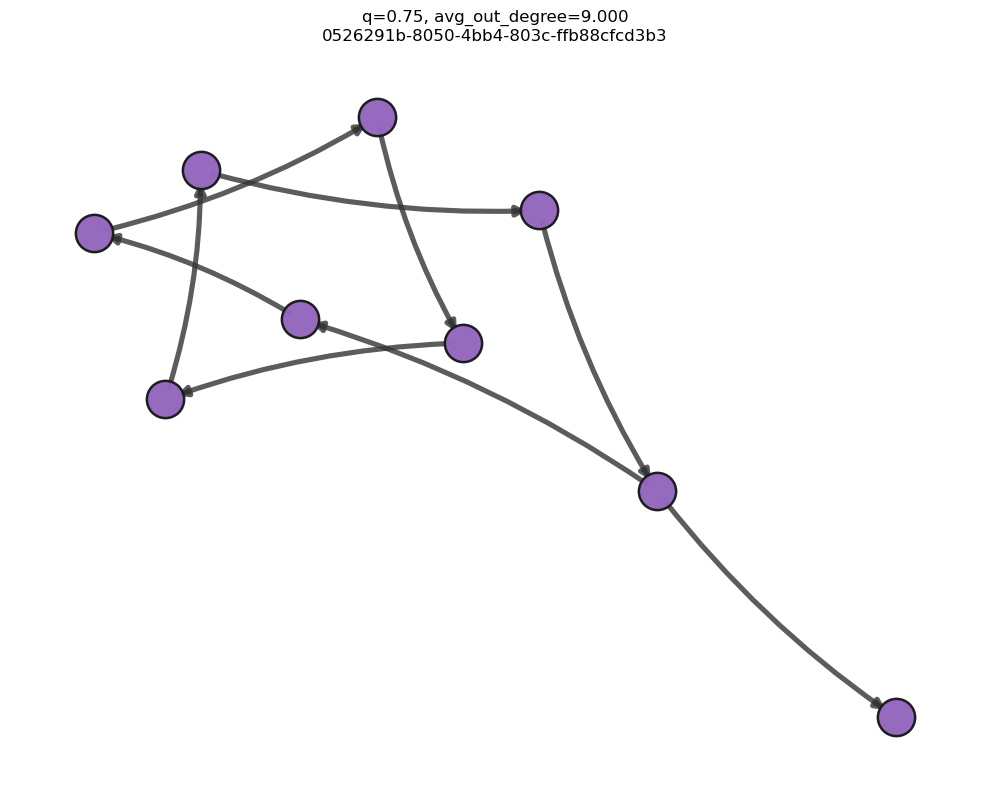

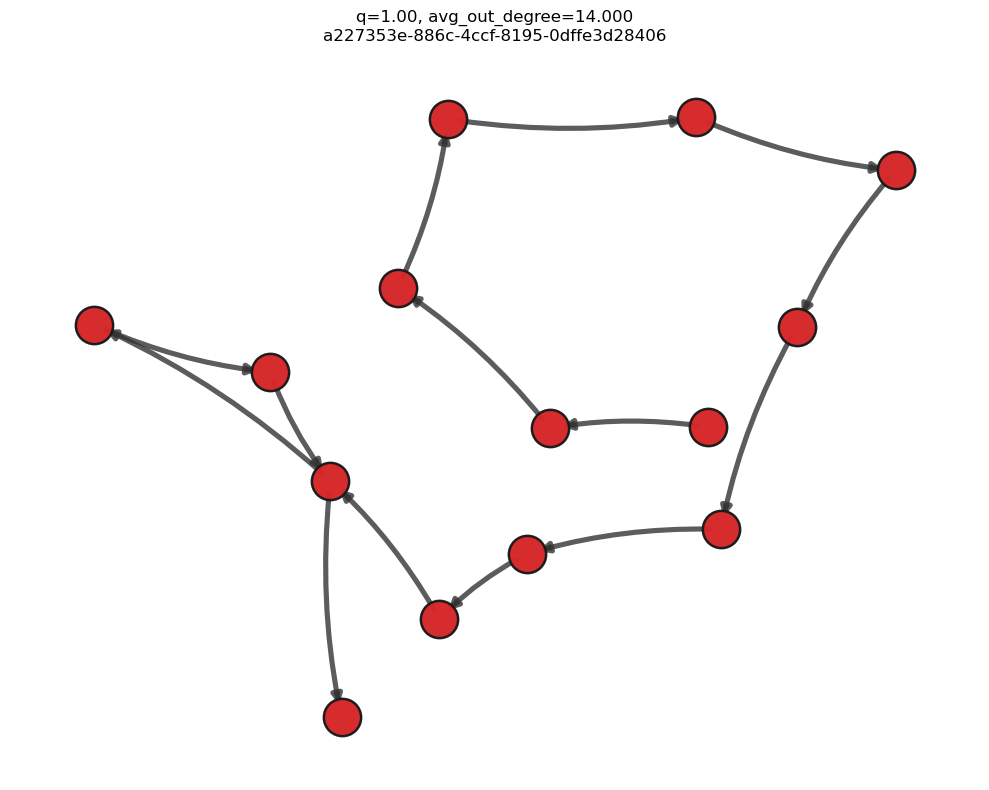

In [62]:
for _, r in out.iterrows():
    cid = r["picked_convo_id"]
    q = round(r["quantile"], 2)
    val = r["picked_value"]

    edges_df = edges_all[edges_all["conversation_id"] == cid]
    if len(edges_df) == 0:
        continue

    G = build_nx_graph(
        edges_df,
        source_col="source",
        target_col="target",
        weight_col="weight",
        directed=True
    )

    color = QUANTILE_COLORS[q]

    title = f"q={q:.2f}, avg_out_degree={val:.3f}\n{cid}"

    draw_graph_pretty(
        G,
        title=title,
        save_path=os.path.join(FIG_DIR, f"global/q{q:.2f}_network.png"),
        show_labels=False,
        graph_color=color
    )


### same node, diff degree

In [35]:
def pick_convos_at_quantiles_fixed_nodes(
    df: pd.DataFrame,
    degree_col: str = "avg_out_degree",
    nodes_col: str = "n_nodes",
    target_nodes: int | None = None,
    tol: int = 0,
    quantiles=(0.0, 0.25, 0.5, 0.75, 1.0),
):
    """
    Pick convo_ids at quantiles of degree_col, but only among convos whose node count
    is (target_nodes ± tol). If target_nodes is None, use the median node count.
    """
    for c in ["convo_id", degree_col, nodes_col]:
        if c not in df.columns:
            raise ValueError(f"Missing column: {c}")

    d = df[["convo_id", degree_col, nodes_col]].dropna().copy()

    if target_nodes is None:
        target_nodes = int(d[nodes_col].median())

    subset = d[(d[nodes_col] >= target_nodes - tol) & (d[nodes_col] <= target_nodes + tol)].copy()
    if subset.empty:
        raise ValueError(
            f"No convos found with {nodes_col} in [{target_nodes - tol}, {target_nodes + tol}]. "
            f"Try a larger tol or choose a different target_nodes."
        )

    targets = subset[degree_col].quantile(list(quantiles)).to_dict()

    rows = []
    for q, target_val in targets.items():
        idx = (subset[degree_col] - target_val).abs().idxmin()
        rows.append({
            "quantile": float(q),
            "target_nodes": int(target_nodes),
            "picked_convo_id": subset.loc[idx, "convo_id"],
            "picked_value": float(subset.loc[idx, degree_col]),
            "picked_nodes": int(subset.loc[idx, nodes_col]),
        })

    return pd.DataFrame(rows).sort_values("quantile").reset_index(drop=True)


In [36]:
out = pick_convos_at_quantiles_fixed_nodes(
    df=df,
    degree_col="avg_out_degree",
    nodes_col="n_nodes",
    target_nodes=None,   # uses median
    tol=0,               # exact same node count
    quantiles=(0, .25, .5, .75, 1)
)
out


,quantile,target_nodes,picked_convo_id,picked_value,picked_nodes
0,0.00,9,05d984c2-1a2e-4bb2-8f4d-98c81fde6664,0.888889,9
1,0.25,9,01a4c01c-cf0e-4f37-ab2b-641bb604af30,1.111111,9
2,0.50,9,024c9be7-c98d-4a2e-b4a9-7884d0b0f626,1.222222,9
3,0.75,9,0159f2d4-f6db-46f8-b7c6-96a3df97b246,1.444444,9
4,1.00,9,0d7fc2a3-37b2-44b8-a60a-c69d6016b65e,2.000000,9


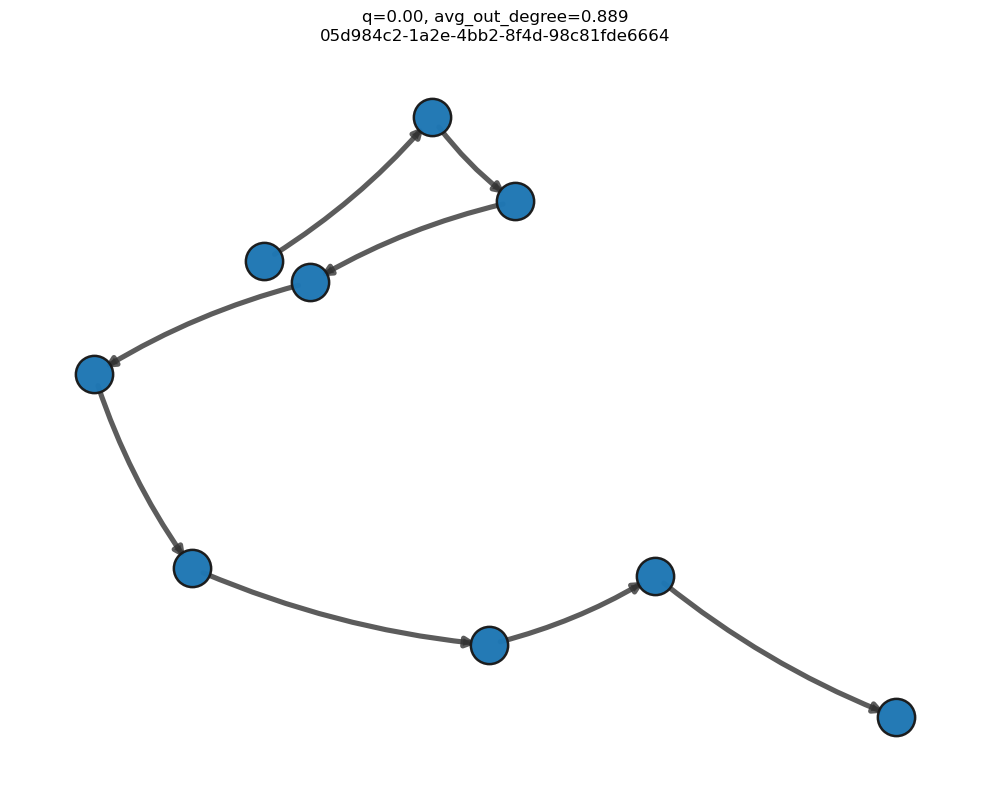

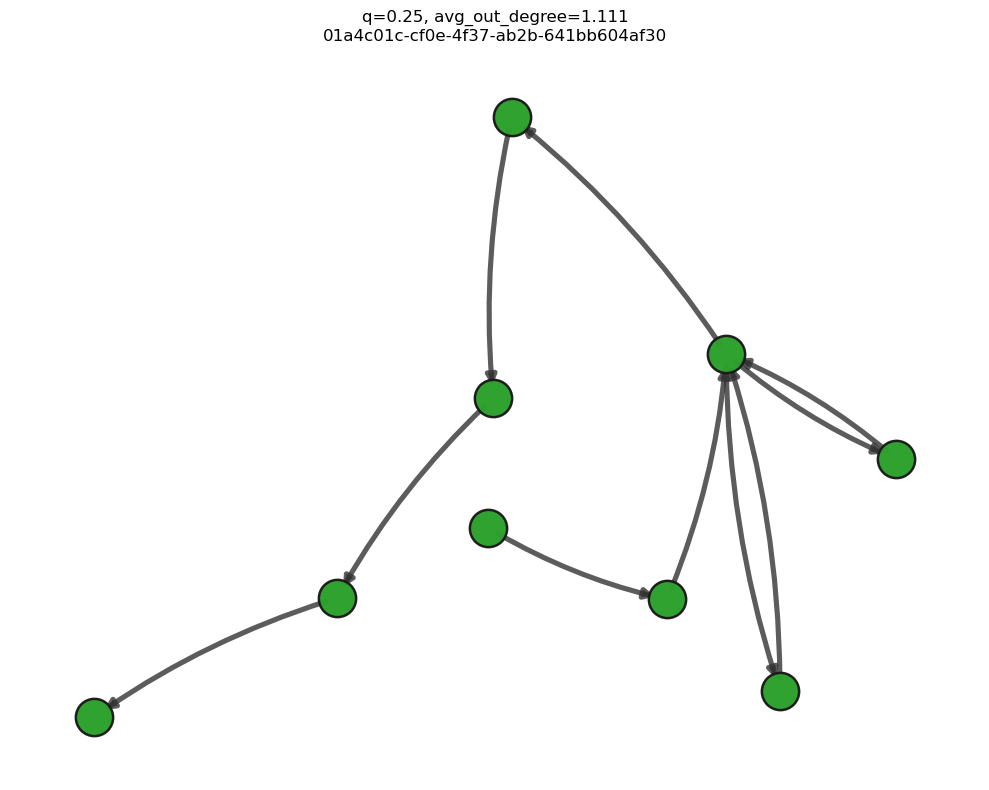

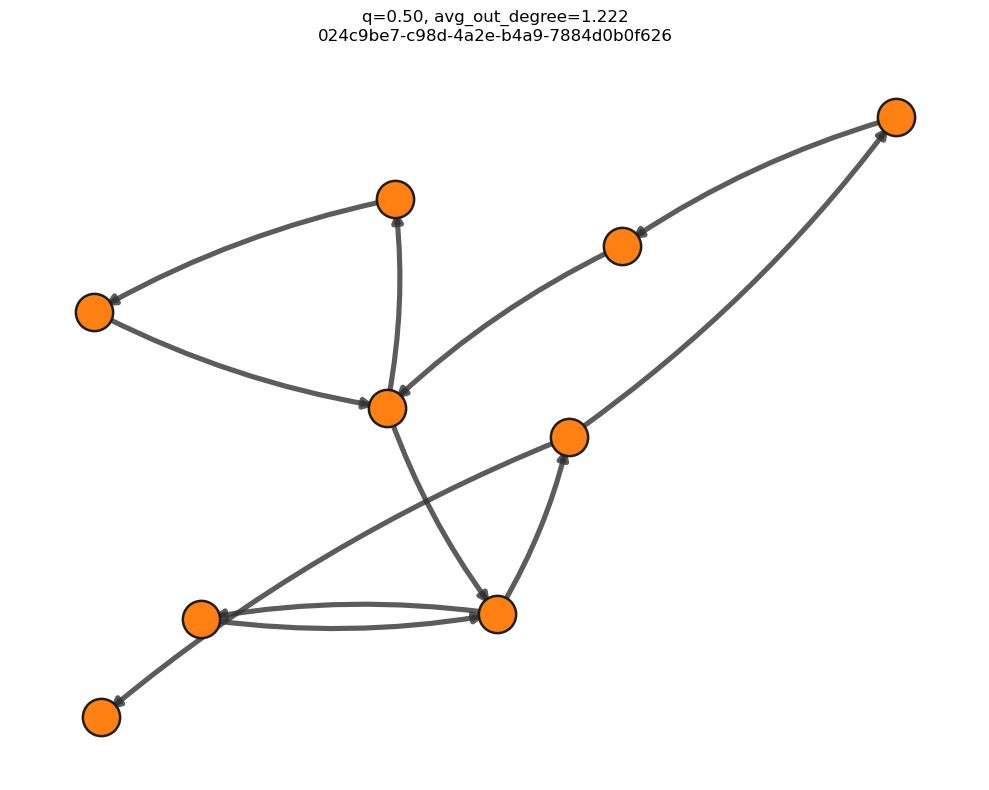

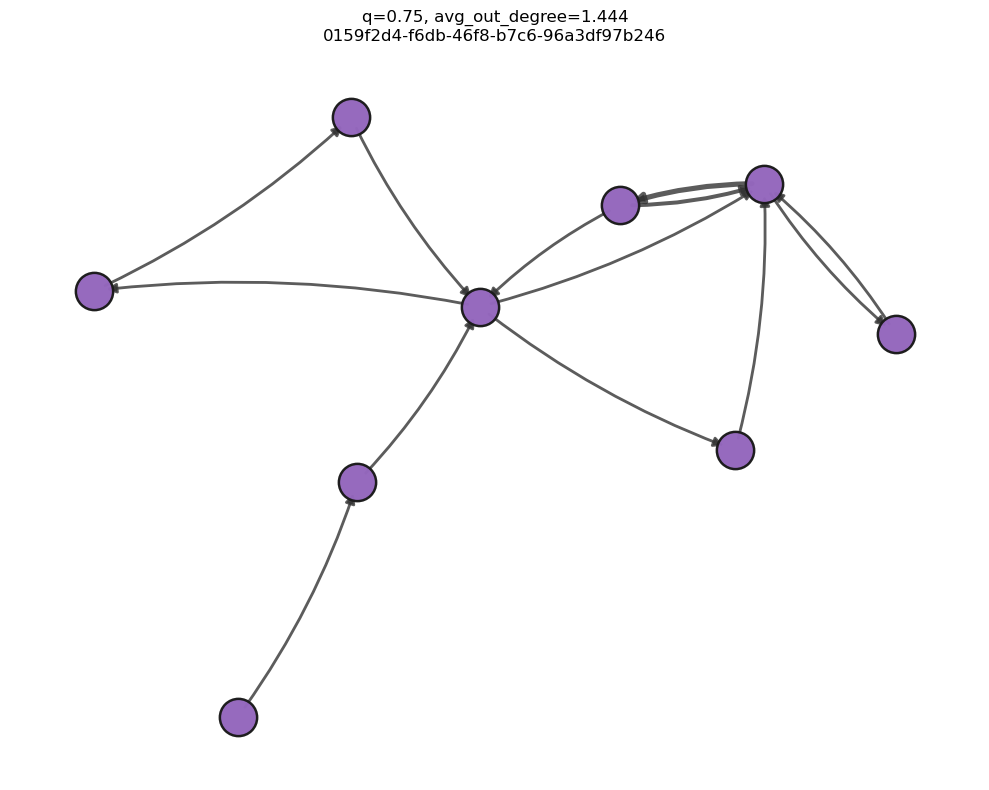

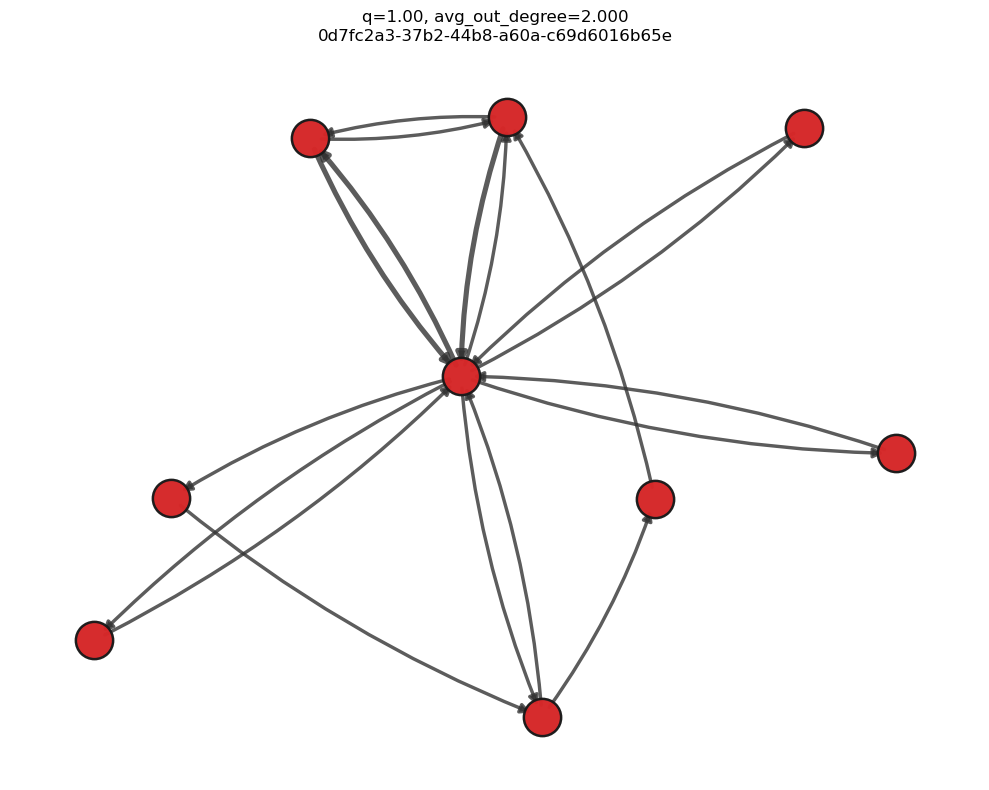

In [37]:
for _, r in out.iterrows():
    cid = r["picked_convo_id"]
    q = round(r["quantile"], 2)
    val = r["picked_value"]

    edges_df = edges_all[edges_all["conversation_id"] == cid]
    if len(edges_df) == 0:
        continue

    G = build_nx_graph(
        edges_df,
        source_col="source",
        target_col="target",
        weight_col="weight",
        directed=True
    )

    color = QUANTILE_COLORS[q]

    title = f"q={q:.2f}, avg_out_degree={val:.3f}\n{cid}"

    draw_graph_pretty(
        G,
        title=title,
        save_path=os.path.join(FIG_DIR, f"9-nodes/q{q:.2f}_network.png"),
        show_labels=False,
        graph_color=color
    )


### same degree, diff nodes

In [38]:
def pick_convos_at_quantiles_fixed_degree(
    df: pd.DataFrame,
    degree_col: str = "avg_out_degree",
    nodes_col: str = "n_nodes",
    target_degree: float | None = None,
    tol: float = 0.0,
    quantiles=(0.0, 0.25, 0.5, 0.75, 1.0),
):
    """
    Pick convo_ids at quantiles of nodes_col, but only among convos whose degree value
    is (target_degree ± tol). If target_degree is None, use the median degree.
    """
    for c in ["convo_id", degree_col, nodes_col]:
        if c not in df.columns:
            raise ValueError(f"Missing column: {c}")

    d = df[["convo_id", degree_col, nodes_col]].dropna().copy()

    if target_degree is None:
        target_degree = float(d[degree_col].median())

    subset = d[(d[degree_col] >= target_degree - tol) & (d[degree_col] <= target_degree + tol)].copy()
    if subset.empty:
        raise ValueError(
            f"No convos found with {degree_col} in [{target_degree - tol}, {target_degree + tol}]. "
            f"Try a larger tol or choose a different target_degree."
        )

    targets = subset[nodes_col].quantile(list(quantiles)).to_dict()

    rows = []
    for q, target_nodes in targets.items():
        idx = (subset[nodes_col] - target_nodes).abs().idxmin()
        rows.append({
            "quantile": float(q),
            "target_degree": float(target_degree),
            "picked_convo_id": subset.loc[idx, "convo_id"],
            "picked_value": int(subset.loc[idx, nodes_col]),        # picked nodes
            "picked_degree": float(subset.loc[idx, degree_col]),
        })

    return pd.DataFrame(rows).sort_values("quantile").reset_index(drop=True)


In [47]:
out = pick_convos_at_quantiles_fixed_degree(
    df=df,
    degree_col="avg_out_degree",
    nodes_col="n_nodes",
    target_degree=1.0,   # uses median degree
    tol=0.0,              # exact same degree; usually you'll want >0
    quantiles=(0, .25, .5, .75, 1)
)
out


,quantile,target_degree,picked_convo_id,picked_value,picked_degree
0,0.00,1.0,5f61a48c-b11b-460e-a4d7-9ef5ca9d857b,2,1.0
1,0.25,1.0,0f6c2eb4-5e44-46c7-8ea5-ddb74702beee,6,1.0
2,0.50,1.0,07dcb0b8-bb2b-427e-b0d0-29e03550c560,8,1.0
3,0.75,1.0,0526291b-8050-4bb4-803c-ffb88cfcd3b3,9,1.0
4,1.00,1.0,a227353e-886c-4ccf-8195-0dffe3d28406,14,1.0


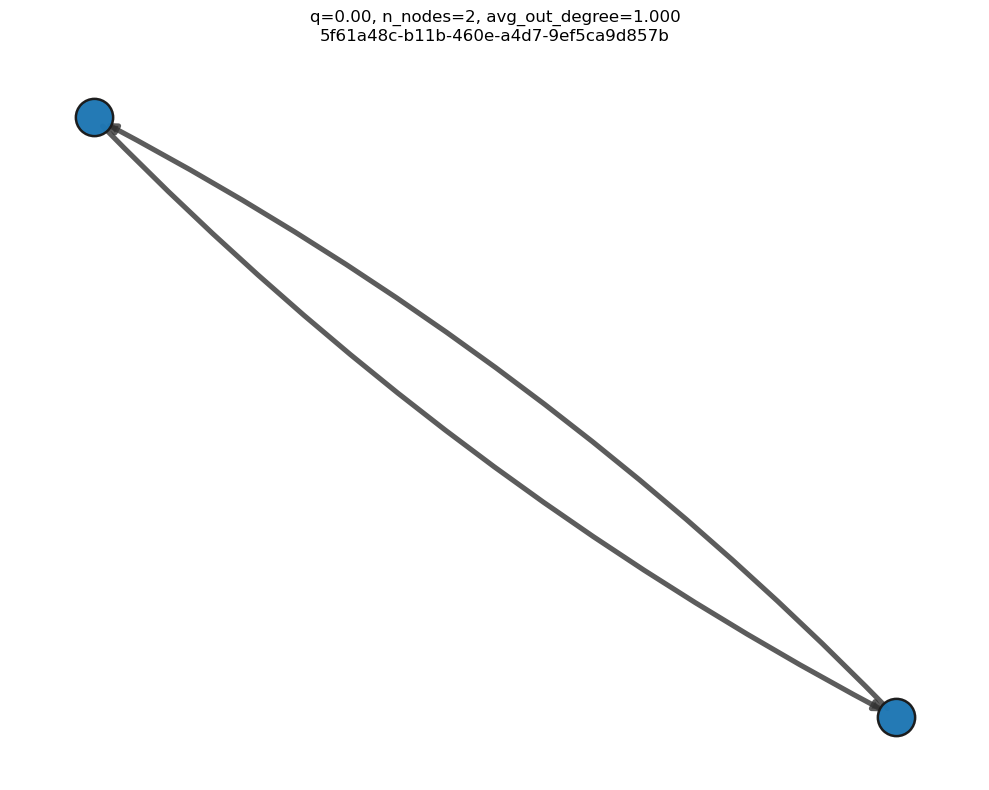

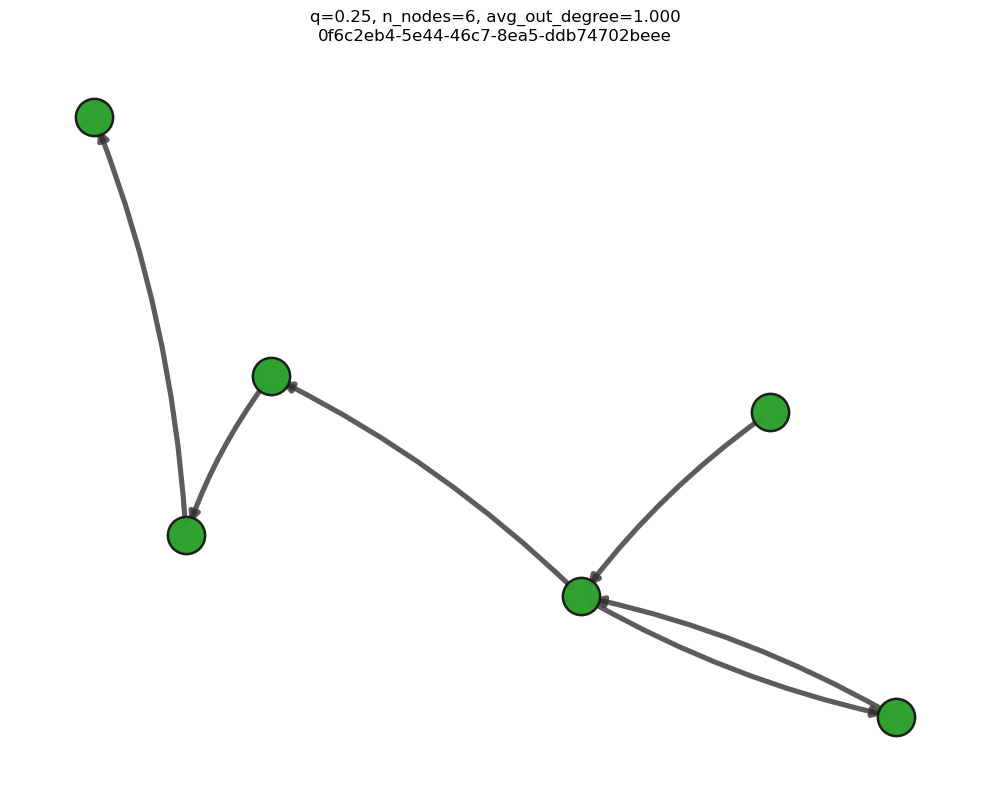

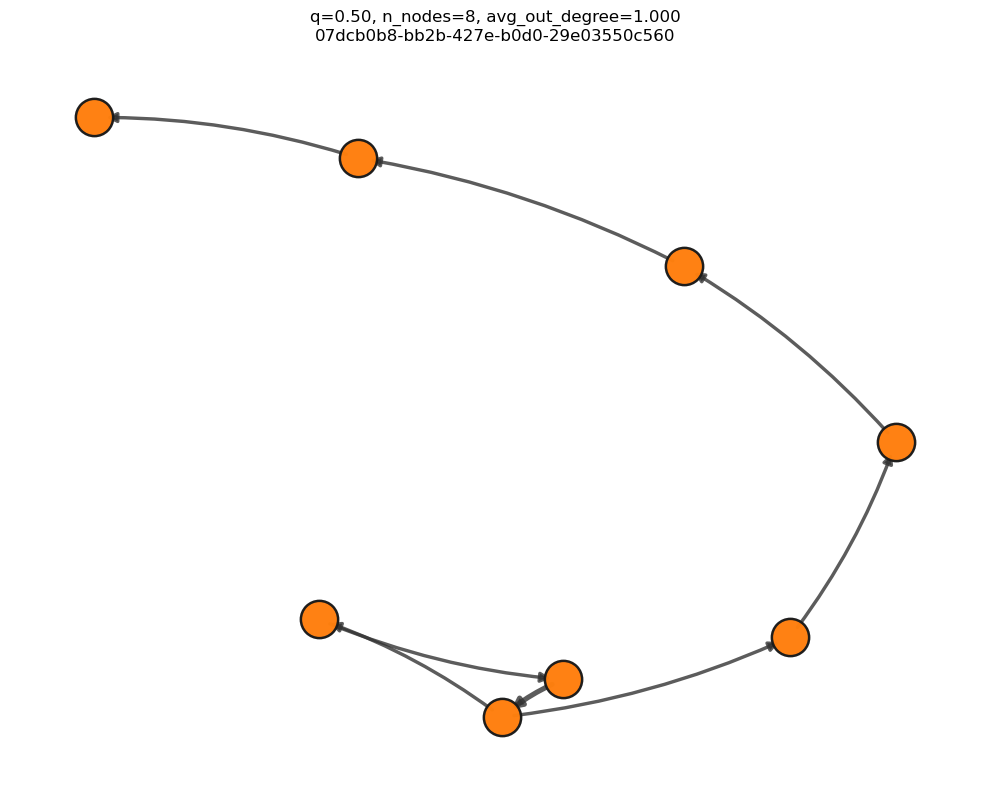

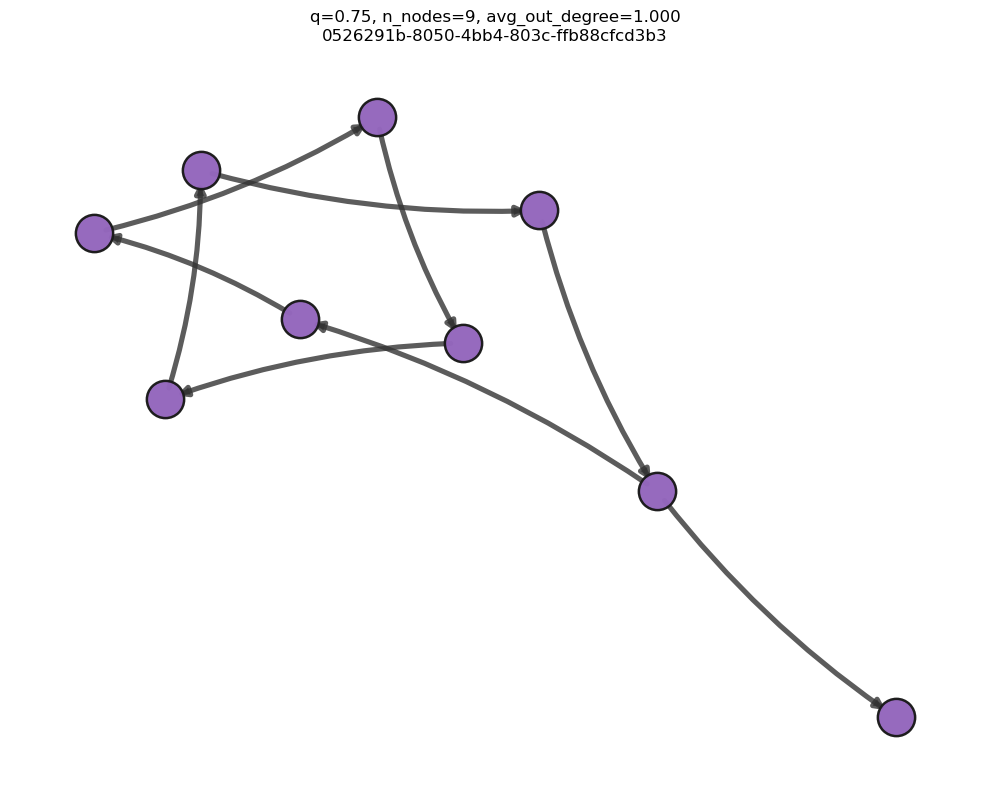

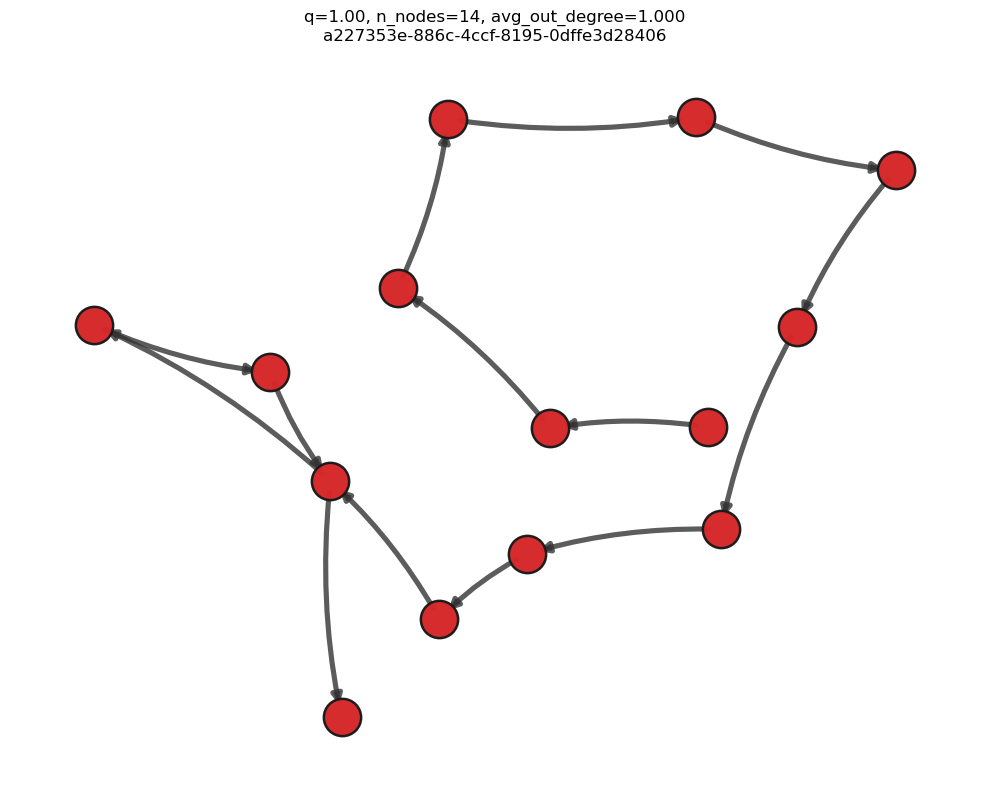

In [48]:
for _, r in out.iterrows():
    cid = r["picked_convo_id"]
    q = round(r["quantile"], 2)

    nodes = r["picked_value"]
    deg = r["picked_degree"]

    edges_df = edges_all[edges_all["conversation_id"] == cid]
    if len(edges_df) == 0:
        continue

    G = build_nx_graph(
        edges_df,
        source_col="source",
        target_col="target",
        weight_col="weight",
        directed=True
    )

    color = QUANTILE_COLORS[q]
    title = f"q={q:.2f}, n_nodes={nodes}, avg_out_degree={deg:.3f}\n{cid}"

    draw_graph_pretty(
        G,
        title=title,
        save_path=os.path.join(FIG_DIR, f"fixed-degree/q{q:.2f}_network.png"),
        show_labels=False,
        graph_color=color
    )


### Specific Network

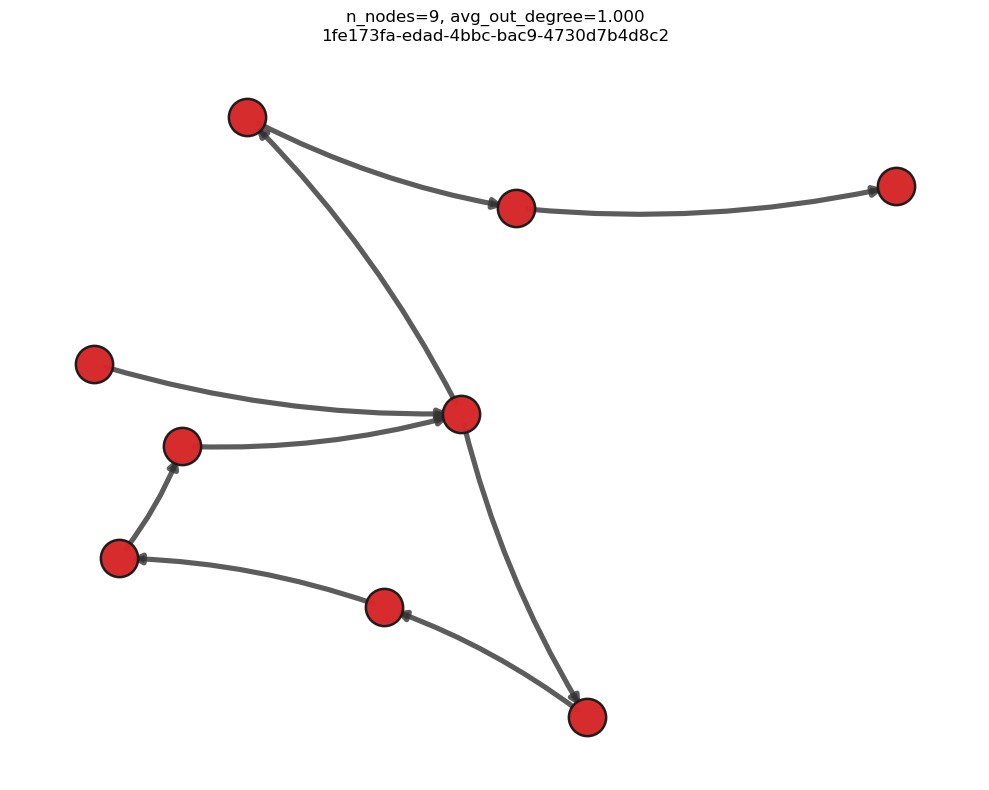

In [72]:
# Set convo_id and run to draw that conversation's topic network
convo_id = "1fe173fa-edad-4bbc-bac9-4730d7b4d8c2"
draw_convo_network(
    convo_id,
    edges_all,
    df=df,
    show_labels=False,
    graph_color="#d62728",  # red
)

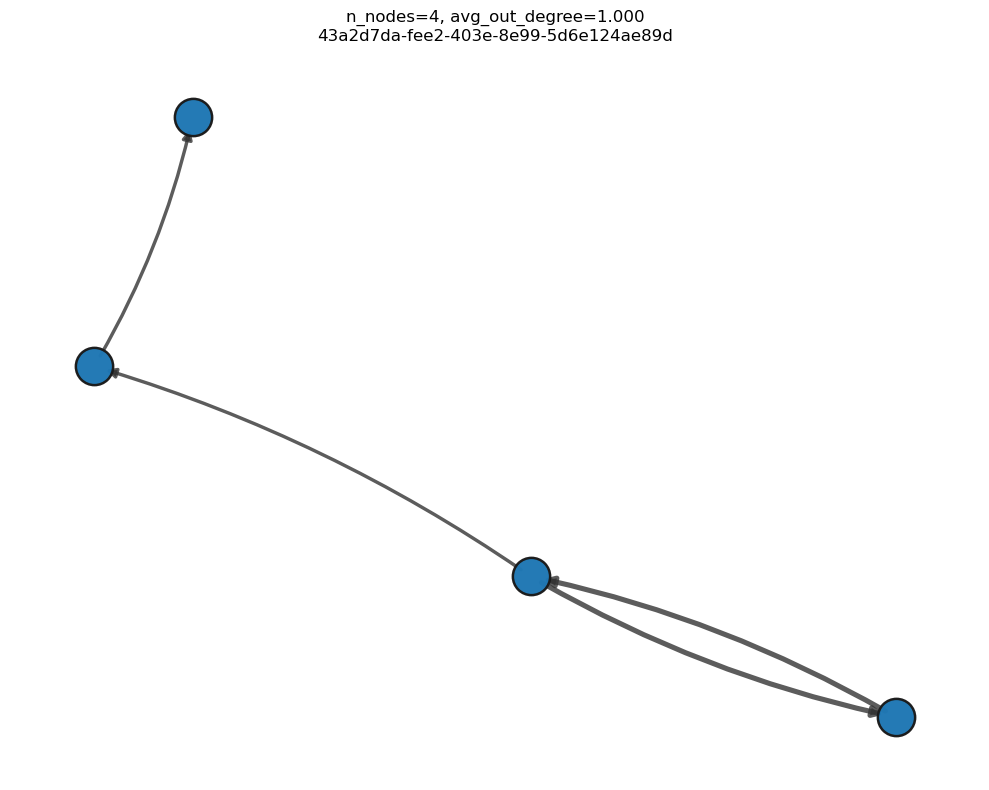

In [68]:
# Set convo_id and run to draw that conversation's topic network
convo_id = "43a2d7da-fee2-403e-8e99-5d6e124ae89d"
draw_convo_network(
    convo_id,
    edges_all,
    df=df,
    show_labels=False,
)